# Fitting a resonator measured in reflection

In [4]:
%cd D:\Github\rf-analysis-tools\resonator_tools
from resonator_tools import circuit
import numpy as np
import pandas as pd
from IPython.display import display
import numpy as np
import xarray as xr


from qcodes import initialise_or_create_database_at, load_by_run_spec


import pandas as pd


D:\Github\rf-analysis-tools\resonator_tools


C:\Users\Amine Selmani\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Although we could use the resonator tools to load data, here we want to use the Pandas library, which is used for statistical data analysis. It can handle many different file types including hdf5.

In [5]:
initialise_or_create_database_at(
    r"D:\Github\Qinu\qumin\data\2025-07-22_C12-034-D_C12-036-I.db"
)
# peak1 = load_by_run_spec(captured_run_id=2).to_xarray_dataset()

In [82]:
peak1 = load_by_run_spec(captured_run_id=11).to_xarray_dataset()#.sel({'pna_power':-30})

Pandas has a very nice way of displaying the data. Let's look at the first few entries:

In [83]:
 display(peak1.head())


<xarray.Dataset> Size: 200B
Dimensions:                   (pna_frequency_axis: 5)
Coordinates:
  * pna_frequency_axis        (pna_frequency_axis) float64 40B 5.419e+09 ... ...
Data variables:
    pna_tr1_linear_magnitude  (pna_frequency_axis) float64 40B 1.519 ... 1.518
    pna_tr1_magnitude         (pna_frequency_axis) float64 40B 3.63 ... 3.627
    pna_tr1_phase             (pna_frequency_axis) float64 40B 121.0 ... 121.0
    pna_tr1_unwrapped_phase   (pna_frequency_axis) float64 40B 121.0 ... 121.0
Attributes: (12/21)
    ds_name:                                   from 5.4193Ghz to 5.4243Ghz , ...
    sample_name:                               C12-036-I
    exp_name:                                  S21 Ch A port 2 
    snapshot:                                  {"station": {"instruments": {"...
    guid:                                      f614fd3d-0000-0000-0000-019837...
    run_timestamp:                             2025-07-23 15:18:35
    ...                                        ...
    git_hash:                                  e99c8309fdc7a6d5f6389b5d2ae6d1...
    main_pna_2D_MxCsweep_multifrequencies:     from instruments.rf.pamela imp...
    main_pna_2D_pnapower_multifrequencies:     from instruments.rf.pamela imp...
    main_pna_fixed_multifrequency:             from instruments.rf.pamela imp...
    multiple_device_pna_fixed_multifrequency:  from instruments.rf.pamela imp...
    comment:                                   VNA+CBL-SMSM+(2m)+RT_switch_po...

Next, we define a reflection port measurement and add the data.

In [57]:
# port2 = circuit.reflection_port(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data_raw=10**(
#     np.log10(((peak1["R"].values / np.sqrt(2)) ** 2 * 1000) / 50))
#     * np.exp(1j * np.pi * peak1["Phi"] / 180),
# )
# port2 = circuit.reflection_port(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data_raw=peak1["R"]/2
#         * np.exp(1j * np.pi * peak1["Phi"] / 180),
# )

# # port2 = circuit.reflection_port(
# #     f_data=peak1["readoutpulsefrequency"].values,
# #     z_data_raw=peak1["I"].values - 1j * peak1["Q"].values,
# # )
# # hv.Curve((peak1["I"].values, peak1["Q"].values), kdims=["I"], vdims=["Q"])
# hv.Curve(
#     (peak1["readoutpulsefrequency"].values, 10 * np.log10((((peak1["R"].values / np.sqrt(2)) ** 2) * 1000) / 50)),
#     kdims=["readoutpulsefrequency"], vdims=["Power (dBm)"]
# )

In [58]:
port2 = circuit.reflection_port(
    f_data=peak1["pna_frequency_axis"],
    z_data_raw=peak1["pna_tr1_linear_magnitude"]
    * np.exp(1j * np.pi * peak1["pna_tr1_unwrapped_phase"] / 180),
)

In [59]:
# hv.Curve((peak1["I"].values, peak1["Q"].values), kdims=["I"], vdims=["Q"])

Perform an automated fit.

In [60]:
port2.autofit()

C:\Users\Amine Selmani\miniconda3\envs\qumin_env\lib\site-packages\resonator_tools-0.1-py3.10.egg\resonator_tools\circlefit.py:148: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.


Let's plot the data and the fit!

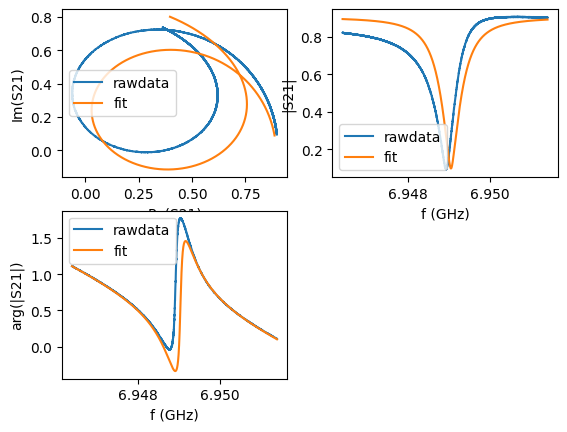

In [61]:
port2.plotall()

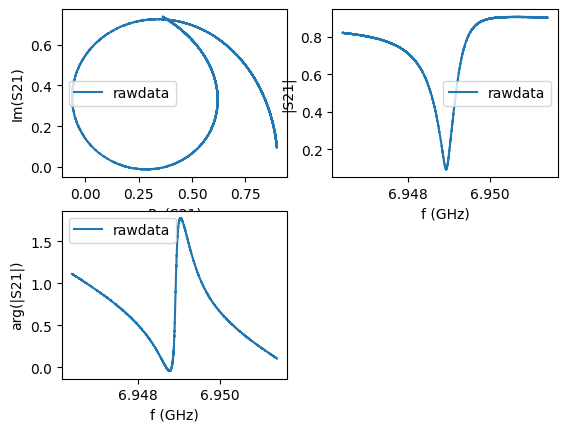

In [81]:
port2.plotrawdata()

In [63]:
# port2.circlefit(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data=peak1["I"].values - 1j * peak1["Q"].values,
# )

AttributeError: Axes.set() got an unexpected keyword argument 'axisbg'

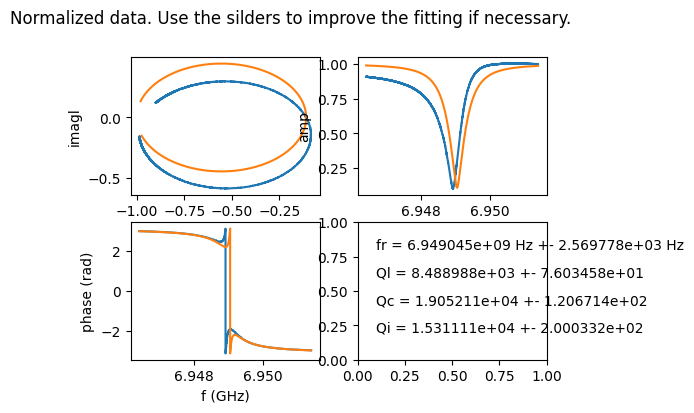

In [64]:

port2.GUIfit()

In [ ]:
port2.plotall()

In [65]:
display(pd.DataFrame([port2.fitresults]).map(lambda x: "{0:.2e}".format(x)))

,Qi,Qc,Ql,fr,theta0,Ql_err,Qc_err,fr_err,chi_square,Qi_err
0,1.53e+04,1.91e+04,8.49e+03,6.95e+09,-3.25e-01,7.60e+01,1.21e+02,2.57e+03,2.03e-02,2.00e+02


In [66]:
print("Single photon limit: %.2f dBm" % port2.get_single_photon_limit())

Single photon limit: -138.77 dBm


In [67]:
print(
    "At -100dBm, we have %.2e photons in the resonator"
    % port2.get_photons_in_resonator(-100)
)

At -100dBm, we have 7.53e+03 photons in the resonator


In [68]:
# port3 = circuit.notch_port(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data_raw=peak1["I"].values - 1j * peak1["Q"].values,
# )
# print()
# port3 = circuit.notch_port(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data_raw=peak1["R"].values 
#     * np.exp(1j * np.pi * peak1["Phi"] / 180),
# )

In [84]:
port3 = circuit.notch_port(
    f_data=peak1["pna_frequency_axis"],
    z_data_raw=peak1["pna_tr1_linear_magnitude"]
    * np.exp(1j * np.pi * peak1["pna_tr1_unwrapped_phase"] / 180),
)

In [85]:
port3.autofit()

C:\Users\Amine Selmani\miniconda3\envs\qumin_env\lib\site-packages\resonator_tools-0.1-py3.10.egg\resonator_tools\circlefit.py:148: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.


In [86]:
# port3.circlefit(
# f_data=peak1["readoutpulsefrequency"].values ,
# z_data=peak1["I"].values - 1j * peak1["Q"].values,
# fr=None,Ql=None,refine_results=True,calc_errors=True)


In [87]:
# port3.do_calibration(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data=peak1["I"].values - 1j * peak1["Q"].values,
# )

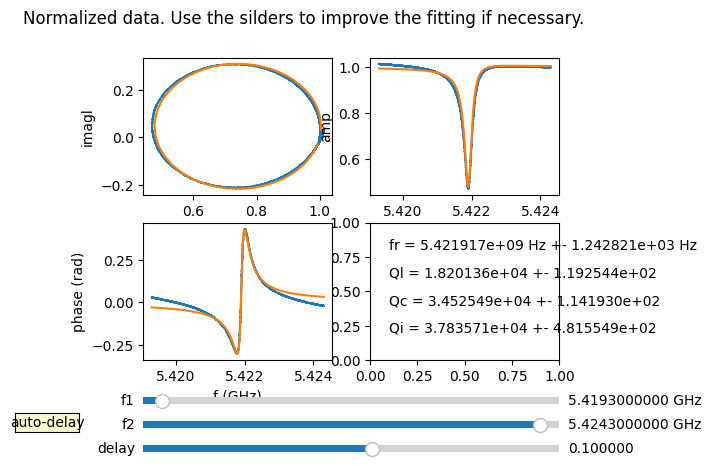

In [88]:
port3.GUIfit()

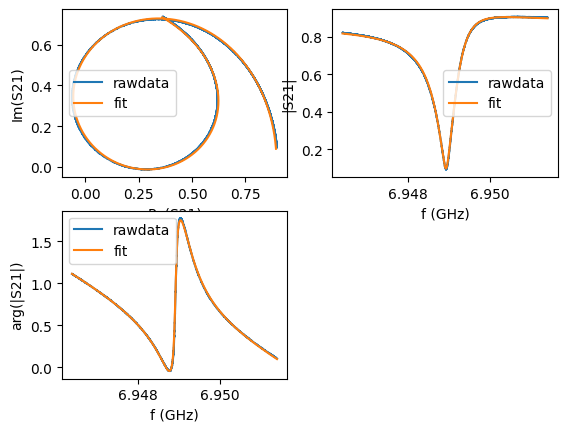

In [74]:
port3.plotall()

Next, let us have a look at the fit results. Here, we convert the dictionary of results into a dataframe to display it in a nicer way.

In [27]:
display(pd.DataFrame([port3.fitresults]).map(lambda x: "{0:.2e}".format(x)))

,Qi_dia_corr,Qi_no_corr,absQc,Qc_dia_corr,Ql,fr,theta0,phi0,phi0_err,Ql_err,absQc_err,fr_err,chi_square,Qi_no_corr_err,Qi_dia_corr_err
0,3.79e+04,3.86e+04,3.47e+04,3.52e+04,1.83e+04,5.42e+09,2.96e+00,-1.77e-01,6.94e-03,1.14e+02,1.14e+02,1.19e+03,1.04e-03,4.65e+02,4.52e+02


In [ ]:
print("Single photon limit: %.2f dBm" % port3.get_single_photon_limit())

In [ ]:
print(
    "At -100dBm, we have %.2e photons in the resonator"
    % port3.get_photons_in_resonator(-100)
)